In [1]:
import jax
import optax

import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from tqdm import tqdm
from flax.training.train_state import TrainState

In [2]:
%config InlineBackend.figure_format = "retina"

## Idea 1:

## An interpolation exercise

In [3]:
key = jax.random.PRNGKey(314)
key_x, key_y, key_iparams = jax.random.split(key, 3)

In [124]:
def f(x):
    return 0.4 + 0.1 * x - 1.2 + jnp.sin(x) * x

In [213]:
n_samples = 200
x = jax.random.uniform(key_x, (n_samples,), minval=-5, maxval=5)
# x = jnp.linspace(-5, 5, n_samples)
errs = jax.random.normal(key_y, (n_samples,)) * 0.4
y = f(x) + errs

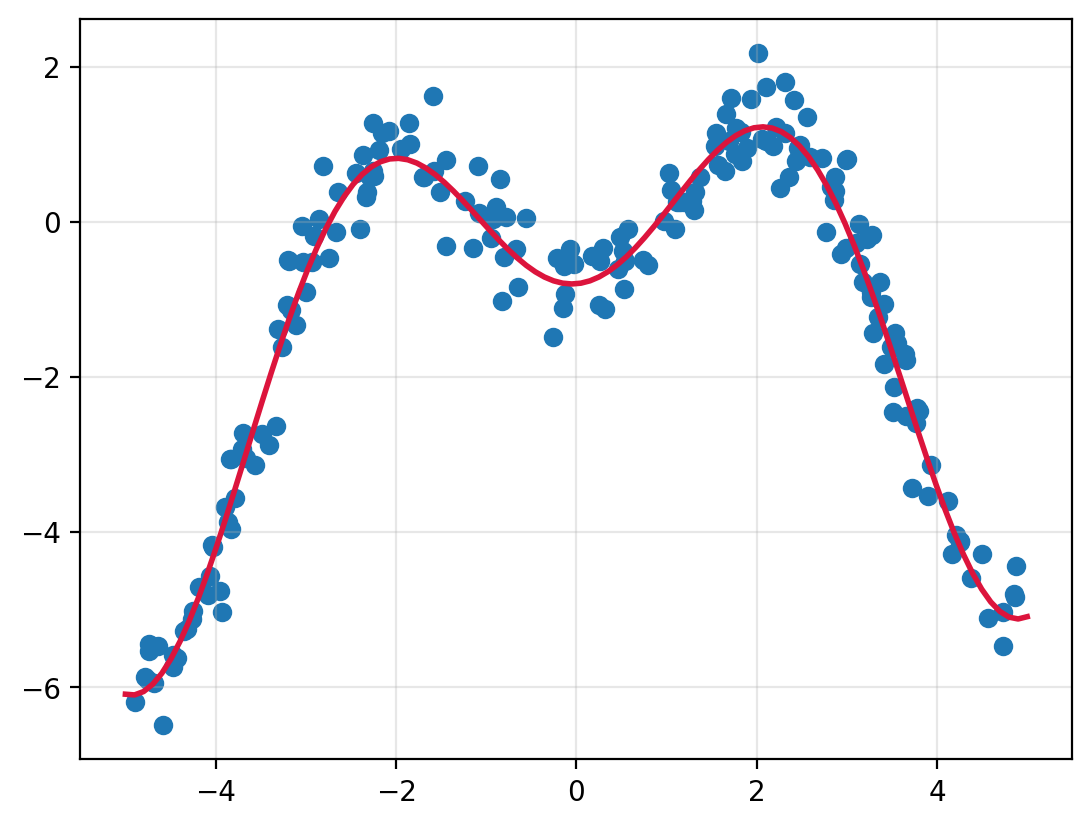

In [214]:
xrange = jnp.linspace(-5, 5, 100)
plt.plot(xrange, f(xrange), c="crimson", linewidth=2)
plt.scatter(x, y)
plt.grid(alpha=0.3)

In [215]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [216]:
model = MLP()
X = x[:, None]
X = jnp.c_[x[:, None], jnp.sin(x[:, None])]
params_init = model.init(key_iparams, X)

In [217]:
def lossfn(params):
    yhat = model.apply(params, X).ravel()
    return jnp.power(y - yhat, 2).mean()

In [218]:
vgloss = jax.value_and_grad(lossfn)

In [219]:
state_init = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-3)
)

In [220]:
def train_step(state, e):
    loss, grads = vgloss(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [221]:
%%time
n_epochs = 1000
state, losses = jax.lax.scan(train_step, state_init, jnp.arange(n_epochs))

CPU times: user 499 ms, sys: 10.8 ms, total: 509 ms
Wall time: 385 ms


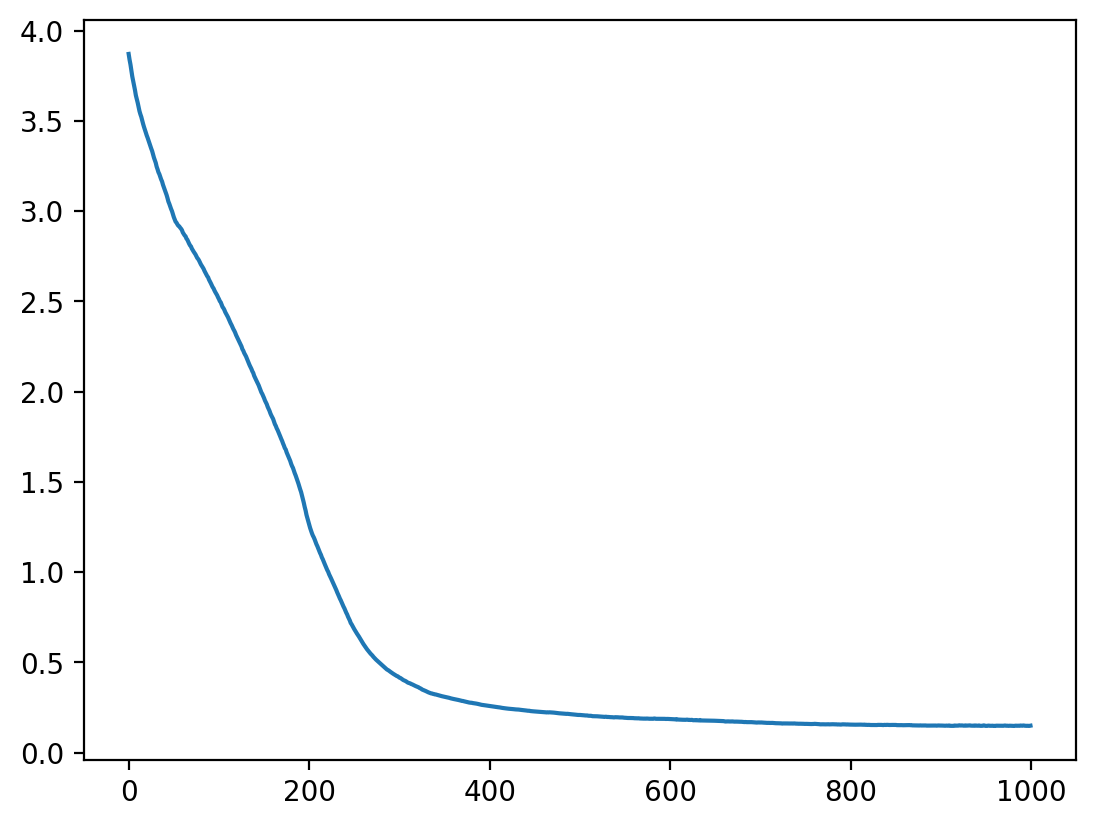

In [222]:
plt.plot(losses)

In [262]:
xrange = jnp.linspace(-5, 5, 200)
Xrange = jnp.c_[xrange, jnp.sin(xrange)]

In [263]:
yeval = model.apply(state.params, Xrange).ravel()

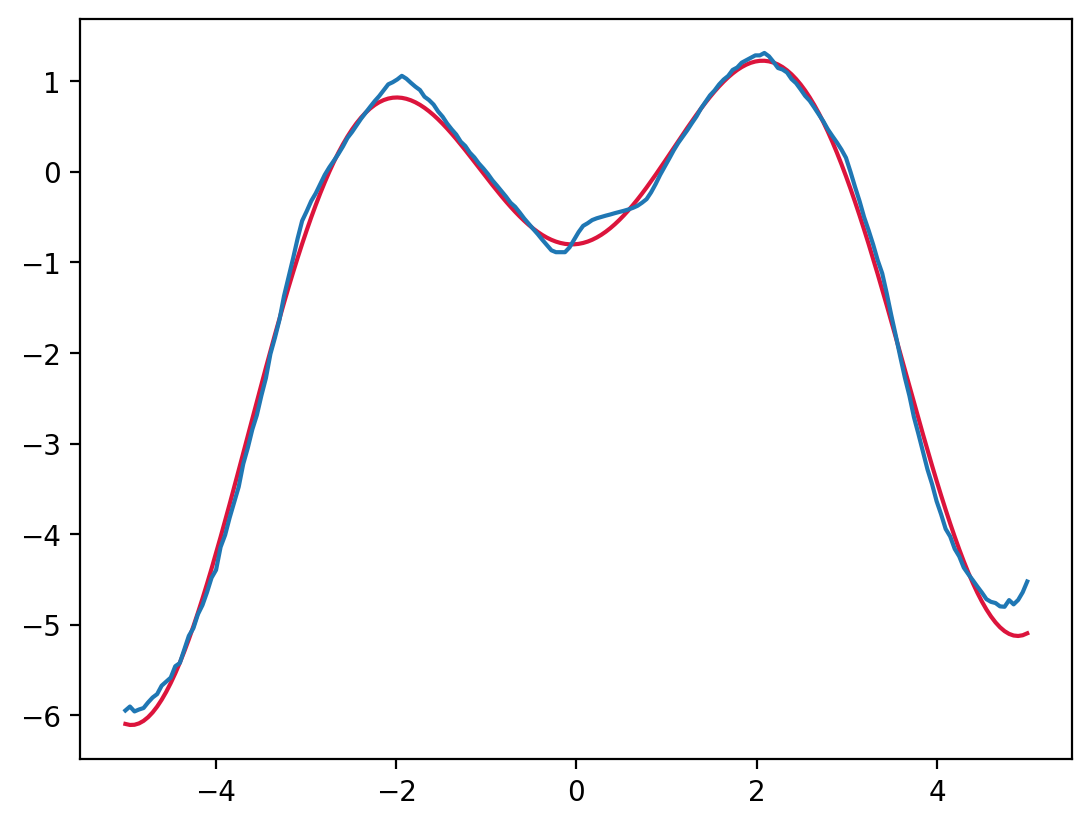

In [264]:
plt.plot(xrange, f(xrange), c="crimson", label="true")
plt.plot(xrange, yeval, label="estimate")

## Kernel regression

In [287]:
@partial(jax.vmap, in_axes=(0, None))
@partial(jax.vmap, in_axes=(None, 0))
def kernel(x, z):
    return jnp.exp(-jnp.power(x - z, 2) / 0.1)

In [288]:
c_values = jnp.linspace(-4, 4, 20)

In [289]:
xrange = jnp.linspace(-5, 5, 200)
xrange.shape

(200,)

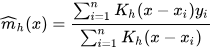

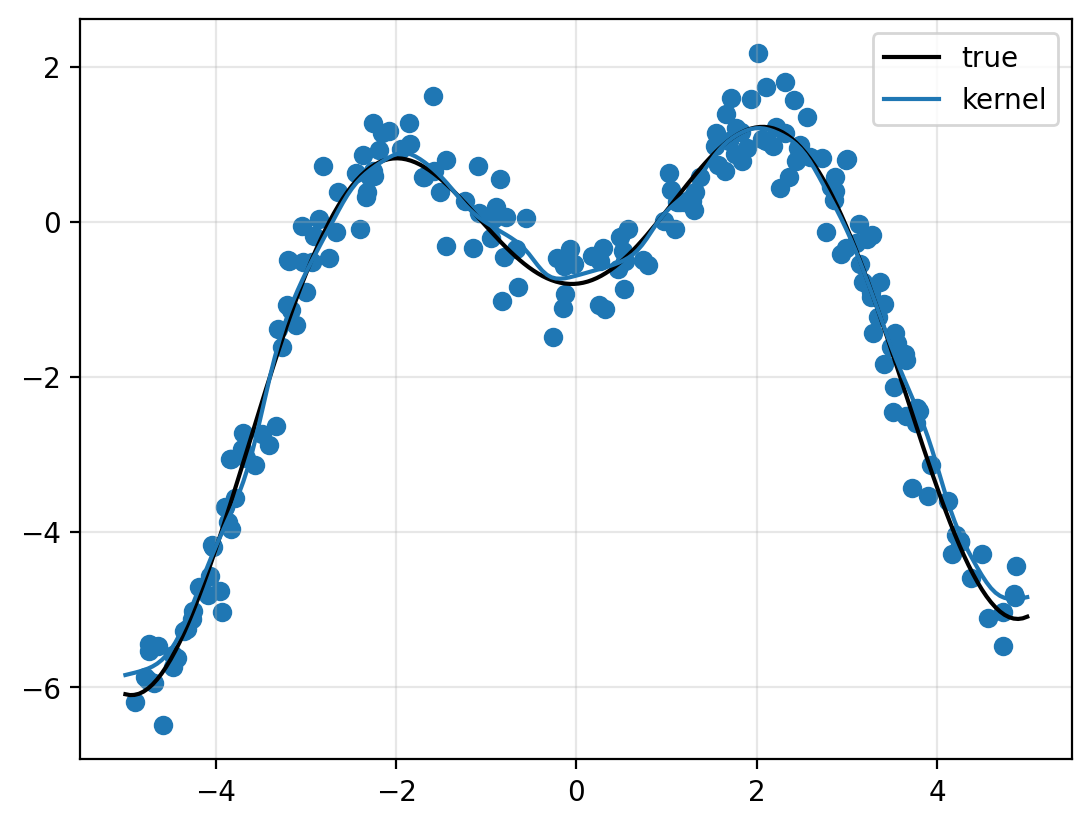

In [290]:
y_est = (kernel(x, xrange) * y[:, None]).sum(axis=0) / kernel(x, xrange).sum(axis=0)

plt.plot(xrange, f(xrange), c="black", label="true")
plt.plot(xrange, y_est, label="kernel")
# plt.plot(xrange, yeval, label="neural network")
plt.scatter(x, y)
plt.grid(alpha=0.3)
plt.legend()